#### This notebook has the results of a long gridsearch that has an accuracy of ~80, but still a poor false positive score (FP) where positive = paid down.  Model is predicting 221,677 loans to have paid down when they actually defaulted.  Need to bring this FP number down

#### key next step: how to improve the FP score? Change the proba threshold value, check the ROC curve for assistance

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 50)

In [2]:
%%time
df = pd.read_parquet('../data/approved.parquet', engine='fastparquet')

Wall time: 15.4 s


In [3]:
df.sample(5)

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,installment,int_rate,issue_d,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,verification_status,zip_code,loan_status
id,,,,,,,,,,,,,,,,,,,,,,,,,,
128396138,AZ,110000.0,Individual,Cash,3.88,2003-04-01,10,Blackjack dealer,779.0,775.0,A,MORTGAGE,w,301.15,5.32,2018-02-01,10000.0,9.0,0.0,0.0,credit_card,A1,36,Not Verified,852xx,1
39641028,CA,70000.0,Individual,Cash,16.31,2006-09-01,1,Business Relationship Manager,684.0,680.0,B,RENT,w,224.20,9.49,2015-01-01,7000.0,17.0,0.0,0.0,debt_consolidation,B2,36,Not Verified,900xx,1
96664053,HI,120000.0,Individual,Cash,4.67,2003-10-01,10,Lead Electrician,694.0,690.0,B,MORTGAGE,w,790.74,11.44,2017-01-01,24000.0,5.0,0.0,0.0,credit_card,B4,36,Not Verified,967xx,1
7286632,UT,47000.0,Individual,Cash,21.40,1997-12-01,4,University of Utah,734.0,730.0,B,OWN,w,576.19,11.99,2013-09-01,17350.0,12.0,0.0,0.0,debt_consolidation,B3,36,Not Verified,841xx,1
93402473,MD,15600.0,Individual,Cash,27.08,2003-07-01,-1,None,669.0,665.0,B,RENT,f,115.40,11.49,2016-11-01,3500.0,10.0,1.0,1.0,credit_card,B5,36,Not Verified,212xx,1


### Feature Engineering

In [4]:
df['days_cr_line']=df['issue_d']-df['earliest_cr_line']
#need to convert to int

### Convert Ordinals

In [5]:
# sub_grade
df.sub_grade.replace({'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5, 'B1':6, 'B2':7, 
                      'B3':8, 'B4':9, 'B5':10, 'C1':11, 'C2':12, 'C3':13, 'C4':14, 
                      'C5':15, 'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20, 'E1':21, 
                      'E2':22, 'E3':23, 'E4':24, 'E5':25}, inplace=True)

# disbursement_method
df.disbursement_method.replace({'Cash':0,'DirectPay':1},inplace=True)

# verification_status
df.verification_status.replace({'Source Verified':'Verified'},inplace=True)
df.verification_status.replace({'Not Verified':0,'Verified':1}, inplace=True)

# initial_list_status
df.initial_list_status.replace({'w':0,'f':1}, inplace=True)

# application_type
df.application_type.replace({'Individual':0,'Joint App':1}, inplace=True)

### Dummification

In [6]:
dummies=['purpose','addr_state','home_ownership']

for d in dummies:
    temp = pd.get_dummies(df[d], prefix=d, prefix_sep='__')
    temp = temp.drop(d+'__'+str(df[d].mode()[0]), axis=1)
    #drop the most common one (mode), making it the base case
    df = pd.concat([df.drop(d, axis=1),temp], axis=1)
    #merge back with main df

### Drop Columns

In [7]:
df.drop(['emp_title','zip_code','grade','issue_d','earliest_cr_line'],axis=1, inplace=True)
#remove earliest_cr_line when fixed

### Drop Rows

In [8]:
df.drop(df[df['emp_length']==-1].index, inplace=True)

In [9]:
df.days_cr_line

id
54734       5660 days
55716       4871 days
55742       2769 days
56121       5054 days
56705       6574 days
               ...   
145620416   4686 days
145622746   5935 days
145623694   8645 days
145627026   7243 days
145636374   5479 days
Name: days_cr_line, Length: 1227022, dtype: timedelta64[ns]

# Modelling

### create target and features

In [10]:
target = df['loan_status']

In [11]:
features = df.drop(['loan_status','days_cr_line'], axis=1)

### note the reduced train_size of .10 = ~120,000 obs
### Note: an extensive Gridsearch will still take over 3 hours

In [68]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, train_size=.10 )
logr = LogisticRegression()
logr_bal = LogisticRegression(class_weight='balanced')

In [62]:
ytrain.value_counts()

1    99630
0    23072
Name: loan_status, dtype: int64

In [60]:
%%time
logr.fit(Xtrain, ytrain)

Wall time: 1.66 s


LogisticRegression()

In [63]:
logr.score(Xtest,ytest)

0.8127082729643581

In [48]:
features

,annual_inc,application_type,disbursement_method,dti,emp_length,fico_range_high,fico_range_low,initial_list_status,installment,int_rate,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,sub_grade,term,verification_status,purpose__car,purpose__credit_card,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,...,addr_state__NJ,addr_state__NM,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,home_ownership__ANY,home_ownership__NONE,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54734,85000.0,0,0,19.48,1,739.0,735.0,1,829.10,11.89,25000.0,10.0,0.0,0.0,9,36,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
55716,30784.0,0,0,16.96,1,669.0,665.0,0,139.15,24.99,3500.0,14.0,1.0,1.0,24,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
55742,65000.0,0,0,14.29,1,709.0,705.0,1,228.22,10.71,7000.0,7.0,0.0,0.0,10,36,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
56121,65000.0,0,0,10.84,10,709.0,705.0,0,245.16,6.49,8000.0,5.0,1.0,1.0,2,36,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56705,33500.0,0,0,18.38,10,704.0,700.0,0,354.89,9.99,11000.0,11.0,0.0,0.0,8,36,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145620416,200000.0,0,0,2.62,10,729.0,725.0,0,467.01,7.56,15000.0,7.0,0.0,0.0,3,36,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
145622746,71000.0,0,0,30.39,4,709.0,705.0,1,71.22,16.91,2000.0,13.0,0.0,0.0,15,36,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
145623694,57000.0,0,0,22.18,4,739.0,735.0,0,507.55,17.97,20000.0,10.0,0.0,0.0,16,60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [65]:
coefs = pd.DataFrame(logr.coef_.T, index=features.columns)

In [66]:
coefs

,0
annual_inc,2.563942e-06
application_type,-1.257408e-06
disbursement_method,8.360577e-06
dti,-2.084417e-02
emp_length,1.657573e-03
...,...
home_ownership__ANY,-2.192562e-06
home_ownership__NONE,1.594699e-07
home_ownership__OTHER,5.804069e-07
home_ownership__OWN,-4.647018e-05


### GridsearchCV

In [15]:
Cs = [0.0001,0.01,1,10]
# cv = KFold(n_splits=5, shuffle=True)

In [16]:
logr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### this gridsearch will take over 3 hours to run.  'solver: liblinear' may be the cause

In [70]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
# cv = KFold(n_splits=5, shuffle=True)
Cs = np.linspace(0.0001,1000,100)
params = [{'C':Cs, 'class_weight':['balanced', 'auto'], 'penalty':['l1','l2'], 'solver':['lbfgs','liblinear']}]
grid_logr = GridSearchCV(estimator=logr, param_grid=params, cv=cv, return_train_score=False)

In [17]:
params = [{'C':Cs}]
grid_logr = GridSearchCV(estimator=logr, param_grid=params)

In [71]:
%%time
grid_logr.fit(Xtrain, ytrain)

Wall time: 3h 39min 22s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-04, 1.01011091e+01, 2.02021182e+01, 3.03031273e+01,
       4.04041364e+01, 5.05051455e+01, 6.06061545e+01, 7.07071636e+01,
       8.08081727e+01, 9.09091818e+01, 1.01010191e+02, 1.11111200e+02,
       1.21212209e+02, 1.31313218e+02, 1.41414227...
       8.08080827e+02, 8.18181836e+02, 8.28282845e+02, 8.38383855e+02,
       8.48484864e+02, 8.58585873e+02, 8.68686882e+02, 8.78787891e+02,
       8.88888900e+02, 8.98989909e+02, 9.09090918e+02, 9.19191927e+02,
       9.29292936e+02, 9.39393945e+02, 9.49494955e+02, 9.59595964e+02,
       9.69696973e+02, 9.79797982e+02, 9.89898991e+02, 1.00000000e+03]),
                          'class_weight': ['balanced', 'auto'],
                          'penalty': ['l1', 'l2'],
                          'solver': ['lbfgs', 'liblinear']}])

In [73]:
print(grid_logr.best_params_)
print(grid_logr.best_score_)

{'C': 90.90918181818182, 'class_weight': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
0.8122035432812119


In [74]:
best_model = grid_logr.best_estimator_

In [75]:
best_model.score(Xtest,ytest)

0.8125090553462765

### Confusion Matrix

In [76]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, best_model.predict(features))

array([[  7711, 221677],
       [  8422, 989212]], dtype=int64)

In [77]:
target.shape

(1227022,)

In [78]:
cmat = confusion_matrix(target,best_model.predict(features))

#Label the confusion matrix
pd.DataFrame(cmat, columns = [f'Pred_{lab}' for lab in best_model.classes_],
             index = [f'True_{lab}' for lab in best_model.classes_])


,Pred_0,Pred_1
True_0,7711,221677
True_1,8422,989212


In [79]:
best_model.classes_

array([0, 1])

In [80]:
target.value_counts()

1    997634
0    229388
Name: loan_status, dtype: int64

### SGD classifier

### Save model in pickle

In [222]:
filename = 'grid_logr_model.sav'
pickle.dump(grid_logr, open(filename, 'wb'))

NameError: name 'pickle' is not defined

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xtest, ytest)
print(result)

In [167]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227022 entries, 54734 to 145636374
Data columns (total 87 columns):
 #   Column                     Non-Null Count    Dtype          
---  ------                     --------------    -----          
 0   annual_inc                 1227022 non-null  float64        
 1   application_type           1227022 non-null  int64          
 2   disbursement_method        1227022 non-null  int64          
 3   dti                        1227022 non-null  float64        
 4   emp_length                 1227022 non-null  int32          
 5   fico_range_high            1227022 non-null  float64        
 6   fico_range_low             1227022 non-null  float64        
 7   initial_list_status        1227022 non-null  int64          
 8   installment                1227022 non-null  float64        
 9   int_rate                   1227022 non-null  float64        
 10  loan_amnt                  1227022 non-null  float64        
 11  open_acc          

In [141]:
df.earliest_cr_line.value_counts()

2016-03-01    43872
2015-10-01    39389
2015-07-01    37620
2015-12-01    35545
2014-10-01    33141
              ...  
2008-01-01        6
2007-11-01        2
2007-12-01        2
2007-08-01        2
2007-10-01        1
Name: issue_d, Length: 136, dtype: int64

In [98]:
df.verification_status.replace({'Source Verified':'Verified'},inplace=True)
df.verification_status.replace({'Not Verified':0,'Verified':1}, inplace=True)

In [101]:
df.initial_list_status.value_counts()

w    764845
f    538238
Name: initial_list_status, dtype: int64

In [99]:
df.verification_status.value_counts()

1    901856
0    401227
Name: verification_status, dtype: int64

#### good practice prob for later

In [59]:
a=df['sub_grade'].unique()

In [51]:
print(sorted(a))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5']


In [62]:
a.sort(axis=0)

In [75]:
grade=[]

for i in range(len(a)):
    b=a[i]+':'+str(i+1)
    grade.append(b)

In [76]:
grade

['A1:1',
 'A2:2',
 'A3:3',
 'A4:4',
 'A5:5',
 'B1:6',
 'B2:7',
 'B3:8',
 'B4:9',
 'B5:10',
 'C1:11',
 'C2:12',
 'C3:13',
 'C4:14',
 'C5:15',
 'D1:16',
 'D2:17',
 'D3:18',
 'D4:19',
 'D5:20',
 'E1:21',
 'E2:22',
 'E3:23',
 'E4:24',
 'E5:25']

In [11]:
df.shape

(1303083, 26)

In [13]:
columns = list(df.columns)
columns

['addr_state',
 'annual_inc',
 'application_type',
 'disbursement_method',
 'dti',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'fico_range_high',
 'fico_range_low',
 'grade',
 'home_ownership',
 'initial_list_status',
 'installment',
 'int_rate',
 'issue_d',
 'loan_amnt',
 'open_acc',
 'pub_rec',
 'pub_rec_bankruptcies',
 'purpose',
 'sub_grade',
 'term',
 'verification_status',
 'zip_code',
 'loan_status']

In [14]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303083 entries, 54734 to 145636374
Data columns (total 26 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   addr_state            1303083 non-null  object        
 1   annual_inc            1303083 non-null  float64       
 2   application_type      1303083 non-null  object        
 3   disbursement_method   1303083 non-null  object        
 4   dti                   1303083 non-null  float64       
 5   earliest_cr_line      1303083 non-null  datetime64[ns]
 6   emp_length            1303083 non-null  int32         
 7   emp_title             1220038 non-null  object        
 8   fico_range_high       1303083 non-null  float64       
 9   fico_range_low        1303083 non-null  float64       
 10  grade                 1303083 non-null  object        
 11  home_ownership        1303083 non-null  object        
 12  initial_list_status   1303083 non-nu

zip_code         1
emp_title    83045
dtype: int64

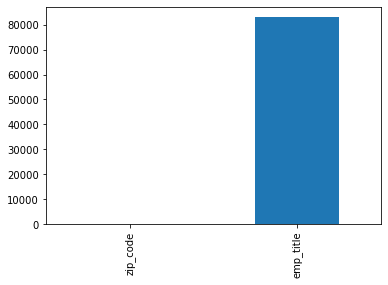

In [15]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
missing

In [26]:
approved.sub_grade.value_counts()

C1    85416
B4    83138
B5    82476
B3    81772
C2    79148
C3    74938
C4    74357
B2    73965
B1    71090
C5    67508
A5    63962
A4    52196
D1    51282
D2    44809
A1    43662
D3    39281
A3    37951
A2    37141
D4    35533
D5    29871
E1    23732
E2    21366
E3    18377
E4    15704
E5    14408
Name: sub_grade, dtype: int64

In [16]:
# df.loan_status.hist()
total = df.shape[0]
pct=[]
for i in approved.loan_status.value_counts():
    pct.append(i/df.shape[0])
pct

[0.8086591567843338, 0.19134084321566625]

In [17]:
missing_list = [i for i in missing.index]
df[missing_list].describe()

,zip_code,emp_title
count,1303082,1220038
unique,943,368008
top,945xx,Teacher
freq,14555,20749


### Imputation

In [9]:
#impute with mean
df['mths_since_recent_bc'].fillna(np.mean(df.mths_since_recent_bc),inplace=True)
df['mo_sin_old_il_acct'].fillna(np.mean(df.mo_sin_old_il_acct), inplace=True)
df['mths_since_recent_inq'].fillna(np.mean(df.mths_since_recent_inq), inplace=True)

#impute with o
df['num_tl_120dpd_2m'].fillna(0, inplace=True)

### Drop columns

In [ ]:
df.drop(['mths_since_last_delinq','mths_since_last_major_derog','mths_since_recent_bc_dlq',
         'mths_since_last_record','mths_since_rcnt_il'], axis=1, inplace=True)

In [18]:
df1 = df.loc[df['zip_code'].isnull()]
df1.loan_status.value_counts()

1    1
Name: loan_status, dtype: int64

In [19]:
df.zip_code.value_counts()

945xx    14555
750xx    14029
112xx    13339
606xx    12090
300xx    11699
         ...  
507xx        1
205xx        1
682xx        1
429xx        1
269xx        1
Name: zip_code, Length: 943, dtype: int64